# 1 Data overview

In this notebook we will catalogue all the HSC and VISTA image information required for processing. The HSC image corners will be used to find the relevant VISTA images required for swarping to the HSC pixel base.

In [1]:
import glob

from astropy.table import Table, Column
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt

import numpy as np

import os

import hashlib
import yaml

In [2]:
def data_loc():
    """Return data locations depending on machine used
    
    Returns
    -------
    str
        Full path to data repository
    """
    if os.path.exists('../local.yml'):
        data_loc = yaml.load(open('../local.yml', 'rb'))['data_loc']
    else:
        data_loc = "/home/ir-shir1/rds/rds-iris-ip005/data/"
    return data_loc
data_loc = data_loc()

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
RUN_HSC = False
RUN_VISTA = True
RESTART_VISTA = False
RUN_PANSTARRS = False

In [4]:
data_loc

'/Users/rs548/GitHub/lsst-ir-fusion/data_local/'

## 1.1 HSC images
First lets look at the HSC images.

In [5]:
images = glob.glob(data_loc + "**/calexp*.fits", recursive=True)

In [6]:
meta = Table()
meta.add_column(Column(data=images, name="file"))

In [7]:
meta

file
str170
"/Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits"


### 1.1.1 Example image

Lets look at one image to check the format and see how to retrieve the key information

In [8]:
hdu = fits.open(meta[0]['file'])

In [9]:
hdu.info()

Filename: /Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1                1 CompImageHDU     34   (4100, 4100)   float32   
  2                1 CompImageHDU     51   (4100, 4100)   int32   
  3                1 CompImageHDU     34   (4100, 4100)   float32   
  4                1 BinTableHDU     40   15615R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5                1 BinTableHDU     76   68R x 15C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  6                1 BinTableHDU     16   303R x 1C   [1QB(32882)]   
  7                1 BinTableHDU     22   301R x 2C   [1D, 1D]   
  8                1 BinTableHDU    103   233R x 19C   [1K, 1D, 1D, 1K, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1D, 1D]   
  9                1 

In [10]:
def cutout_scale(im, num_min = 2.0, num_max = 5.0):
    """
    Takes an image array and returns the vmin and vmax required to scale the image 
    between median + 5 * sigma MAD and median - 2 * sigma MAD
    """

    import numpy as np
    import astropy.stats as apys

    data = im.flatten()   #Return a copy of the array collapsed into one dimension

    try:
        med = np.median(data[np.isnan(data)!=1])
        sigma_MAD = apys.mad_std(data[np.isnan(data)!=1])
    except IndexError:
        med = 0.0
        sigma_MAD = 0.0
    vmax = med + num_max * sigma_MAD
    vmin = med - num_min * sigma_MAD

    return vmin, vmax
vmin, vmax = cutout_scale(hdu[1].data)

In [11]:
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HIERARCH variance_scale = 1.23089751151746                                      
BGMEAN  =  0.00541533444420293                                                  
BGVAR   = 3.29746708310884E-05                                                  
AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to 
HIERARCH COADD_INPUTS_ID =   1 / archive ID for coadd inputs catalogs           
HIERARCH AP_CORR_MAP_ID = 15283 / archive ID for aperture correction map        
PSF_ID  =                153

In [12]:
hdu[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4100 / length of original image axis                  
NAXIS2  =                 4100 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
WCSAXES =                    2 / Number of WCS axes                             
CRPIX1  =               18000. / Reference pixel on axis 1                      
CRPIX2  =               18000. / Reference pixel on axis 2                      
CRVAL1  =     148.760330578512 / Value at ref. pixel on axis 1                  
CRVAL2  =     3.719008264462

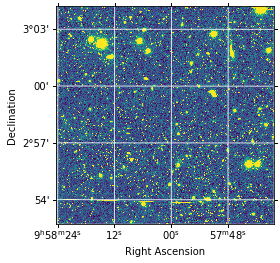

In [13]:


#hdu = fits.open(filename)[0]
#wcs = WCS(hdu.header)
wcs = WCS(hdu[1].header)

plt.subplot(projection=wcs)
plt.imshow(hdu[1].data, vmin=vmin, vmax=vmax, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

In [14]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 148.760330578512  3.71900826446281  
CRPIX : 18000.0  18000.0  
CD1_1 CD1_2  : -4.666666666663e-05  0.0  
CD2_1 CD2_2  : 0.0  4.666666666663e-05  
NAXIS : 4100  4100

#### Critical imformation
From each image we need:

1. Corner pixels
2. File sizes
3. Checksums

In [15]:
hdu[1].header['NAXIS1']

4100

In [16]:

ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
print(ra,dec)

[149.60124143 149.6014238  149.40971945 149.40986029] [2.87875888 3.07003912 2.87888383 3.0701724 ]


In [17]:
meta[0]['file']

'/Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits'

In [18]:
%%timeit
1==1

32.4 ns ± 1.47 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [19]:
def file_as_bytes(file):
    with file:
        return file.read()

test_hash = hashlib.md5(file_as_bytes(open(meta[0]['file'], 'rb'))).hexdigest()
print( test_hash)

f6329f24da5497ee9b3a947b720007dd


In [20]:
%%timeit
h = hashlib.md5(file_as_bytes(open(meta[0]['file'], 'rb'))).hexdigest()

502 ms ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(str(round((150000*0.5)/(60*60))) + ' hours')

21 hours


### 1.2.2 Run on all images
Now lets loop over all the images

In [22]:
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_0_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_0_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_x_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_x_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_0_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_0_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_x_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_x_y'))
meta.add_column(Column(data=np.full(len(meta),  0), name='size'))
meta.add_column(Column(data=np.full(len(meta),  ''), name='hash', dtype='S{}'.format(len(test_hash))))

In [51]:

for im in meta:
    if not RUN_HSC:
        break
    file = im["file"]
    #print(file)
    hdu = fits.open(file)
    wcs = WCS(hdu[1].header)
    ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
    im['ra_0_0'] = ra[0]
    im['ra_0_y'] = ra[1]
    im['ra_x_0'] = ra[2]
    im['ra_x_y'] = ra[3]
    im['dec_0_0'] = dec[0]
    im['dec_0_y'] = dec[1]
    im['dec_x_0'] = dec[2]
    im['dec_x_y'] = dec[3]   
    im['size'] =  os.stat(im['file']).st_size
    im['hash'] = hashlib.md5(file_as_bytes(open(im['file'], 'rb'))).hexdigest()

In [52]:
meta[:10].show_in_notebook()

idx,file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash
0,"/Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits",149.60124143150958,149.60142380055666,149.40971944781666,149.40986028949584,2.878758884472921,3.070039119384859,2.878883831353908,3.0701723953854674,196171200,f6329f24da5497ee9b3a947b720007dd


In [25]:
if RUN_HSC:
    meta.write('./data/hsc_images_overview.csv', overwrite=True)

## 1.2 VISTA images

Now lets investigate the VISTA images.

In [26]:
v_files = glob.glob(data_loc + "private/VISTA/**/*.fit", recursive=True)

In [27]:
print(len(v_files))

62


In [29]:
v_hdu = fits.open(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00266_st.fit')

In [30]:
v_hdu.info()

Filename: /Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00266_st.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  DET1.CHIP1    1 CompImageHDU    273   (2127, 2133)   int32   
  2  DET1.CHIP2    1 CompImageHDU    273   (2127, 2132)   int32   
  3  DET1.CHIP3    1 CompImageHDU    273   (2127, 2132)   int32   
  4  DET1.CHIP4    1 CompImageHDU    273   (2127, 2132)   int32   
  5  DET1.CHIP5    1 CompImageHDU    273   (2127, 2131)   int32   
  6  DET1.CHIP6    1 CompImageHDU    273   (2126, 2132)   int32   
  7  DET1.CHIP7    1 CompImageHDU    273   (2127, 2132)   int32   
  8  DET1.CHIP8    1 CompImageHDU    273   (2127, 2132)   int32   
  9  DET1.CHIP9    1 CompImageHDU    273   (2127, 2132)   int32   
 10  DET1.CHIP10    1 CompImageHDU    273   (2127, 2131)   int32   
 11  DET1.CHIP11    1 CompImageHDU    273   (2127, 2131)   int32   
 12  DET1.CHIP12    1 CompImageHDU    27

In [31]:
v_hdu[0].header


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2018-09-12T05:10:22'         / Date this file was written            
TELESCOP= 'VISTA   '                    / ESO Telescope Name                    
INSTRUME= 'VIRCAM  '                    / Instrument used.                      
OBJECT  = 'No name '           / Original target.                               
RA      =            52.637254          / 03:30:32.9 RA (J2000) pointing (deg)  
DEC     =            -28.546

In [32]:
# ESO DET IRACE ADC12 ENABLE
v_hdu[1].header['HIERARCH ESO DET CHIP NO']

1

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


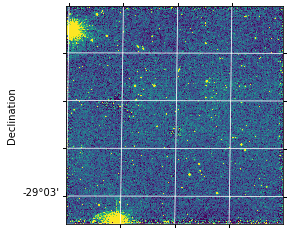

In [34]:
def plot_fits(im_hdu):
    wcs = WCS(im_hdu[1].header)
    #wcs = WCS(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00266_st.fit')
    vmin, vmax = cutout_scale(im_hdu[1].data)
    plt.subplot(projection=wcs)
    plt.imshow(im_hdu[1].data, vmin=vmin, vmax=vmax, origin='lower')
    plt.grid(color='white', ls='solid')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    
plot_fits(v_hdu)

In [35]:
w = WCS(v_hdu[1].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


In [36]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZPN'  'DEC--ZPN'  
CRVAL : 52.6383143242083  -28.5460589755779  
CRPIX : 5395.518  6876.345  
CD1_1 CD1_2  : -2.41867964639161e-07  -9.47983785096966e-05  
CD2_1 CD2_2  : 9.48241130816871e-05  -2.54505885971959e-07  
NAXIS : 2127  2133

In [37]:
ra, dec = w.all_pix2world([0,0,v_hdu[1].header['NAXIS1'],v_hdu[1].header['NAXIS1']], 
                            [0,v_hdu[1].header['NAXIS2'],0,v_hdu[1].header['NAXIS2']], 1) 
print(ra,dec)

[53.37909551 53.15113771 53.37854269 53.15061895] [-29.0495698  -29.05249728 -28.85020311 -28.85263031]


In [38]:
v_meta = Table()
v_meta.add_column(Column(data=v_files, name="file"))

In [39]:
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_0_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_0_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_x_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_x_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_0_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_0_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_x_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_x_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  '        '), name='filter'))
v_meta.add_column(Column(data=np.full(len(v_meta),  0), name='size'))
v_meta.add_column(Column(data=np.full(len(v_meta),  ''), name='hash', dtype='S{}'.format(len(test_hash))))

In [59]:
n_im = 0
if RESTART_VISTA:
    checkpoints = glob.glob('./data/vista_images_overview_temp_*.csv')
    n_im = np.max(np.array([int(t.split('_')[-1][:-4] ) for t in checkpoints] ))
    restart_file = './data/vista_images_overview_temp_{}.csv'.format(n_im)
    print("Restarting with: {}".format(restart_file))
    v_meta = Table.read(restart_file)
    #START_VISTA

In [65]:

for im in v_meta[v_meta['size']==0]:
 
    if not RUN_VISTA:
        break
    file = im["file"]
    #print(file)
    n_im += 1
    try:
        hdu = fits.open(file)
        wcs = WCS(hdu[1].header)
        ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
        this_file = v_meta['file'] == file
        v_meta['ra'][this_file] = hdu[0].header['RA']
        v_meta[this_file]['dec'] = hdu[0].header['DEC']
        v_meta[this_file]['ra_0_0'] = ra[0]
        v_meta[this_file]['ra_0_y'] = ra[1]
        v_meta[this_file]['ra_x_0'] = ra[2]
        v_meta[this_file]['ra_x_y'] = ra[3]
        v_meta[this_file]['dec_0_0'] = dec[0]
        v_meta[this_file]['dec_0_y'] = dec[1]
        v_meta[this_file]['dec_x_0'] = dec[2]
        v_meta[this_file]['dec_x_y'] = dec[3]   
        v_meta[this_file]['size'] =  os.stat(im['file']).st_size
        v_meta[this_file]['hash'] = hashlib.md5(file_as_bytes(open(im['file'], 'rb'))).hexdigest()
        filt = hdu[0].header['HIERARCH ESO INS FILT1 NAME']
        
    except:
        pass
    if n_im % 10000 == 0:
        v_meta.write('./data/vista_images_overview_temp_{}.csv'.format(n_im), overwrite=True)
        
    

/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00306_st.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00298_st.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00291.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00285.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00284.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290_st_conf.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00279.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00286.fit
Y
/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00292.fit
Y
/Users/rs548/Git

In [64]:
v_meta.show_in_notebook()

idx,file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash
0,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00306_st.fit,52.428817,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
1,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00298_st.fit,52.428625,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
2,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00291.fit,52.431046,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
3,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00285.fit,52.637079,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
4,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00284.fit,52.633621,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
5,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290.fit,52.428646,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
6,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290_st_conf.fit,52.428646,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
7,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00279.fit,52.642433,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
8,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00286.fit,52.634362,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,
9,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00292.fit,52.424554,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,


In [43]:
if RUN_VISTA:
    v_meta.write('./data/vista_images_overview.csv', overwrite=True)

## PanSTARRS catalogues

The PanSTARRS catalogues are organised into 'shards'. These are defined by HEALPIX.